In [62]:
# Imports
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
from collections import Counter
from matplotlib import cm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from ipywidgets import interact
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import stopwords
from collections import defaultdict
import wordcloud
import re

#set seaborn style
sns.set()
sns.set_style("whitegrid")

#### Load the Data

In [63]:
df = pd.read_csv("data.csv", low_memory=False)

#### Clean Data

In [64]:
# Clean the date
df["Date"] = df["Date"].replace(to_replace=r'T.*', value='', regex=True)
df["Date"] = pd.to_datetime(df["Date"])

# Drop the ID column
df.drop("Id", axis=1, inplace=True)

In [65]:
df.head()

,Title,Company,Date,Location,Area,Classification,SubClassification,Requirement,FullDescription,LowestSalary,HighestSalary,JobType
0,Casual Stock Replenisher,Aldi Stores,2018-10-07,Sydney,North West & Hills District,Retail & Consumer Products,Retail Assistants,Our Casual Stock Replenishers pride themselves...,NaN,0,30,NaN
1,Casual Stock Replenisher,Aldi Stores,2018-10-07,Richmond & Hawkesbury,NaN,Retail & Consumer Products,Retail Assistants,Our Casual Stock Replenishers pride themselves...,NaN,0,30,NaN
2,RETAIL SALES SUPERSTARS and STYLISTS Wanted - ...,LB Creative Pty Ltd,2018-10-07,Brisbane,CBD & Inner Suburbs,Retail & Consumer Products,Retail Assistants,BRAND NEW FLAGSHIP STORE OPENING - SUNSHINE PLAZA,NaN,0,30,NaN
3,Team member - Belrose,Anaconda Group Pty Ltd,2018-10-07,Gosford & Central Coast,NaN,Retail & Consumer Products,Retail Assistants,Bring it on - do you love the great outdoors a...,NaN,0,30,NaN
4,"Business Banking Contact Centre Specialist, Ni...",Commonwealth Bank - Business & Private Banking,2018-10-07,Sydney,Ryde & Macquarie Park,Call Centre & Customer Service,Sales - Inbound,"We are seeking highly articulate, enthusiastic...",NaN,0,30,NaN


## Case Study 1

To determine the best subjects and skills to learn and recommend to Matthew, a first year student in computer science, several analyses were performed.

### Textual Analysis - skills extraction for IT sector from **FullDescription**

Textual analysis of keywords contained in the **FullDescription** column was performed using feature extraction in the sklearn python library. Using the extracted keywords, a **word cloud** was created to visually present the keywords by word importance.

In [67]:
classificationDf = df.copy()
classifications = classificationDf['Classification'].dropna().unique()

stop_words = stopwords.words('english')
custom_stopwords = ['skill', 'want', 'position', 'role', 'required', 'requirement', 'requirements', 'responsibilities', 'tasks', 'duties', 'experience',
                    'applicant', 'candidate', 'team', 'work', 'job', 'manage', 'assist', 'support', 'help', 'esure', 'provide', 'lead', 'handle', 
                    'maintain', 'oversee', 'coordinate', 'execute', 'motivated', 'passionate', 'dynamic', 'enthusiastic', 'driven', 'reliable', 
                    'flexible', 'proactive', 'eager', 'excellent', 'strong', 'self-motivated']

for word in custom_stopwords:
    stop_words.append(word)

In [68]:
def update(Classification="Information & Communication Technology"):
    requirements = df[classificationDf['Classification']==Classification]['Requirement'].dropna()
    original_documents = [x.strip() for x in requirements] 

    tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = stop_words, max_features=200)

    features = tfidf.fit(original_documents)
    corpus_tf_idf = tfidf.transform(original_documents) 

    sum_words = corpus_tf_idf.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in tfidf.vocabulary_.items()]
    words_freq_dict = {x: y for x,y in words_freq}
    words_freq_dict.items()
    #print(sorted(words_freq, key = lambda x: x[1], reverse=True)[:5])

    word_cloud = wordcloud.WordCloud(width=1280,height=720,background_color='white',colormap='viridis')
    word_cloud.generate_from_frequencies(words_freq_dict)

    plt.figure(figsize=(16,16))
    plt.imshow(word_cloud,interpolation='bilinear')
    plt.axis("off")
    plt.title('TF-IDF Analysis of Requirements', size=14)
    plt.show()
    
interact(update, Classification=classifications)

interactive(children=(Dropdown(description='Classification', index=13, options=('Retail & Consumer Products', …

<function __main__.update(Classification='Information & Communication Technology')>

#### Observation
* The keywords with the most importance in the **FullDescription** attribute in the dataset were:
    - Contract
    - Join
    - Opportunity
    - Business
    - Looking
    - Experienced
    - Project
    - Developer
    - Data
    - Senior
    - Analyst
    - Client
    - Manager
    - Engineer
* From these keywords, the words with most relevance for what skills or subjects to learn are: **business**, **experienced**, **project**, **developer**, **data**, **analyst**, **client**, **manager**, an **engineer**.
* These keywords suggest learning the following subjects or skills based on the current ICT job market:
    - Taking internships to gain experience
    - Learn the skill of working in a team through group projects
    - Learning about businesses through university subjects
    - Software development subjects skills
    - Data analytics subjects and skills
    - Systems analyst
    - Improving communication skills to be able to work well with clients
    - Management skills
    - Taking engineering courses and subjects

### Analysis of Popularity of Programming Languages

In [70]:
Classification = df[df['Classification']=="Information & Communication Technology"]['Requirement'].dropna()
Classification = Classification.str.lower()

skills = ["Python", "Java", "JavaScript", "C", "C++", "C#", "Go", "Rust", "Kotlin", "Swift", "Ruby", "PHP", "TypeScript", 
                    "Shell", "Bash", "SQL", "PowerShell", "Dart", "Objective-C", "Scala", "R", "MATLAB", "Groovy", "Perl", "Lua", 
                    "Assembly", "Haskell", "Elixir", "Erlang", "VB.NET", "F#", "SAS", "HTML", "CSS", "Solidity", "Terraform", "YAML", "JSON"]
skills_counts = defaultdict(int)

for skill in skills:
    pattern = r'\b' + re.escape(skill.lower()) + r'\b'
    skills_counts[skill] = Classification.str.count(pattern).sum()
skills_sorted = sorted(skills_counts.items(), key=lambda x: x[1], reverse=True)

# for skill, count in skills_sorted:
#     print(f"{skill}: {count}")

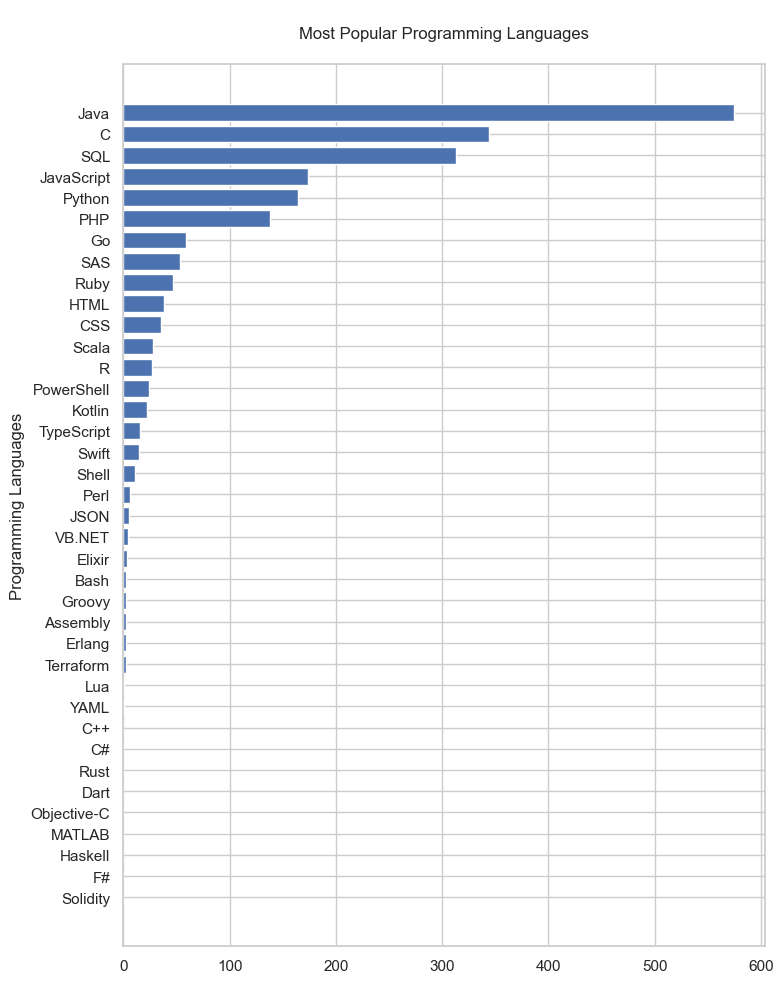

In [72]:
skills, counts = zip(*skills_sorted)

plt.figure(figsize=(8, 10))
plt.barh(skills, counts, color='b')
plt.title("\nMost Popular Programming Languages\n")
plt.ylabel('Programming Languages')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Observation
A horizontal bar chart presenting the most used programming languages used in the ICT sector was created.
* The most popular Programming language in the ICT sector was **Java** with 570 mentions in the dataset.
* The top 6 programming languages were **Java**, **C**, **SQL**, **JavaScript**, **SQL**, **Python**, and **PHP** in descending order of popularity.
*  There is a significant drop in mentions of programming languages after the 6th most popular programming language of **PHP**

In [74]:
itDf = df[df['Classification']=='Information & Communication Technology']
itDf = itDf.groupby('SubClassification').count()
itDf['SubClassification'] = itDf.index
itDf['Count'] = itDf['Classification']
itDf.sort_values('Count', ascending=False, inplace=True)
itDf.head()

,Title,Company,Date,Location,Area,Classification,Requirement,FullDescription,LowestSalary,HighestSalary,JobType,SubClassification,Count
SubClassification,,,,,,,,,,,,,
Developers/Programmers,4211,4090,4211,4211,3147,4211,4211,3955,4211,4211,3955,Developers/Programmers,4211
Business/Systems Analysts,2986,2954,2986,2986,2097,2986,2986,2713,2986,2986,2713,Business/Systems Analysts,2986
Programme & Project Management,2413,2381,2413,2413,1651,2413,2413,2182,2413,2413,2182,Programme & Project Management,2413
Architects,1548,1540,1548,1548,1053,1548,1548,1442,1548,1548,1442,Architects,1548
Engineering - Software,1437,1417,1437,1437,1102,1437,1437,1370,1437,1437,1370,Engineering - Software,1437


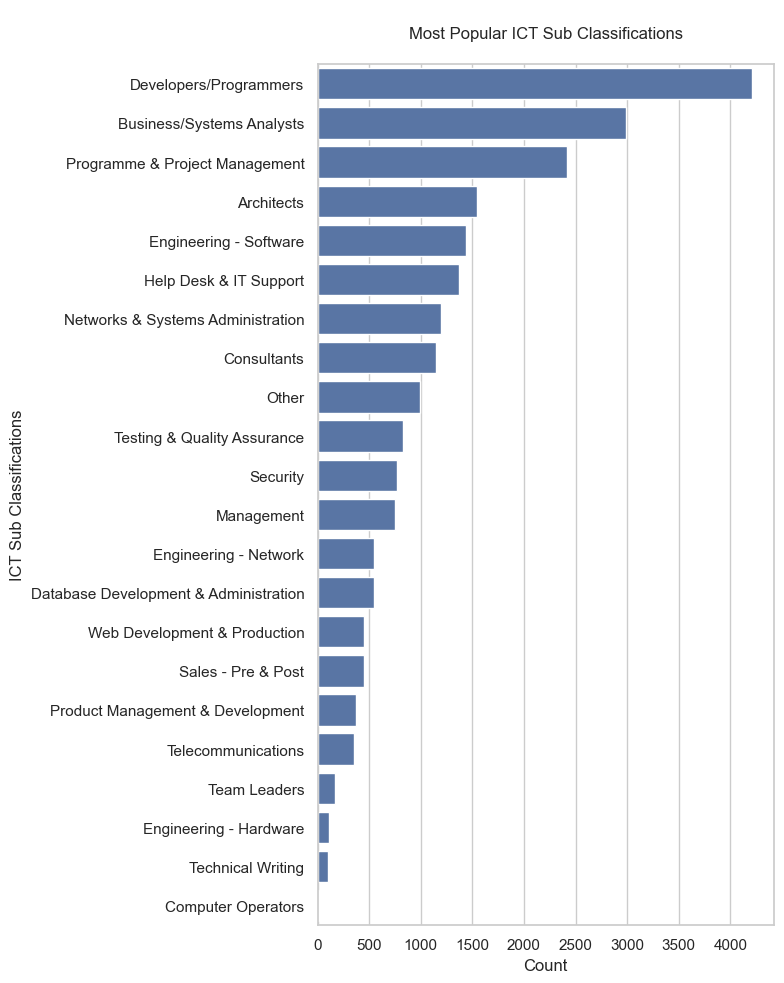

In [76]:
plt.figure(figsize=(8, 10))
sns.barplot(data=itDf, x='Count', y='SubClassification', color="b")
plt.title("\nMost Popular ICT Sub Classifications\n")
plt.ylabel('ICT Sub Classifications')
plt.tight_layout()
plt.show()

#### Observation
The ICT sub classifications with most job posts were graphed on a horizontal bar chart to gain insight of the ICT jobs with most job posts.
* The most popular ICT sub classification was **developers/programmers** with approximately 4200 job posts.
* The top 5 ICT sub classifications are **developer/programmers**, **business/systems analysis**, **programme & project management**, **architect**, and **software engineering**.

### Evaluation
The skills and subjects that I would recommend to a first year student in computer science to be successful in the future are:
* Team working skills
* Software development
* Knowledge on systems
* Communication skills
* Engineering subjects
* Business subjects
It is also important to gain experience through internships.

Additionally, I would recommend learning the following programming languages:
* Java
* C
* Python
* SQL

Learning these skills will open career pathways to the following ICT sub sectors:
* Developer/programmers
* Business/System analysis
* Project management
* Software engineering

## Case Study 2

### Evaluation
TalentFinders is an agent that finds the most suitable jobs from an employees CV based on the requirements of each sector. To develop this agent, the following steps must be undertaken:
* Text extraction on the employee CV to obtain relavent stopwords for textual analysis on job market data
* Textual analysis on job post descriptions
* Generate the word cloud of most frequent words in job descriptions and skill lists to find a suitable sector.
* Generate another word cloud of the words only in the descriptions for the jobs in the sector.
* Determine the best sector and sub sectors from the two word clouds.

In [85]:
if 'Classification' in df.columns:
    classifications = ['All'] + df['Classification'].dropna().astype(str).unique().tolist()
    classifications.sort()
else:
    print("Warning: 'Classification' column not found in DataFrame. Defaulting to empty list.")
    classifications = ['All']

if 'SubClassification' in df.columns:
    all_sub_classifications_list = df['SubClassification'].dropna().astype(str).unique().tolist()
    all_sub_classifications_list.sort()
else:
    print("Warning: 'SubClassification' column not found in DataFrame. Sub-classification relevance graph may not function.")
    all_sub_classifications_list = []

if 'Requirement' in df.columns:
    all_requirements_text = df['Requirement'].dropna().tolist()
    global_tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df=1, stop_words=stop_words)
    global_tfidf_vectorizer.fit(all_requirements_text)
else:
    print("Error: 'Requirement' column not found in DataFrame. Cannot initialize TF-IDF vectorizer.")
    global_tfidf_vectorizer = TfidfVectorizer()

sub_classification_vectors = {}
if 'SubClassification' in df.columns and 'Requirement' in df.columns:
    for cls in df['SubClassification'].dropna().unique():
        cls_str = str(cls)
        sub_cls_requirements = df[df['SubClassification'] == cls_str]['Requirement'].dropna().tolist()
        if sub_cls_requirements:
            sub_cls_tfidf_matrix = global_tfidf_vectorizer.transform(sub_cls_requirements)
            sub_classification_vectors[cls_str] = np.asarray(sub_cls_tfidf_matrix.mean(axis=0))
        else:
            sub_classification_vectors[cls_str] = np.zeros((1, len(global_tfidf_vectorizer.vocabulary_)))
else:
    print("Warning: Cannot pre-calculate sub-classification vectors without 'SubClassification' and 'Requirement' columns. Relevance graph for sub-classifications will be limited.")


def update(Classification="All", Candidate_Skills=""):
    if 'Classification' not in df.columns or 'SubClassification' not in df.columns or 'Requirement' not in df.columns:
        print("Error: DataFrame 'df' must contain 'Classification', 'SubClassification', and 'Requirement' columns for full functionality.")
        plt.close('all')
        return

    filtered_df_for_wordcloud = df.copy()

    if Classification != "All":
        filtered_df_for_wordcloud = filtered_df_for_wordcloud[filtered_df_for_wordcloud['Classification'] == Classification]

    requirements_for_wordcloud = filtered_df_for_wordcloud['Requirement'].dropna()
    original_documents_for_wordcloud = [x.strip() for x in requirements_for_wordcloud]

    if not original_documents_for_wordcloud:
        print(f"No requirements found for the classification: '{Classification}'. Word cloud cannot be generated.")
        plt.close('all')
    else:
        local_tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = stop_words)
        local_tfidf.fit(original_documents_for_wordcloud)
        corpus_tf_idf = local_tfidf.transform(original_documents_for_wordcloud)

        sum_words = corpus_tf_idf.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in local_tfidf.vocabulary_.items()]
        words_freq_dict = {x: y for x,y in words_freq}

        word_cloud = wordcloud.WordCloud(width=1280,height=720,background_color='white',colormap='viridis')
        word_cloud.generate_from_frequencies(words_freq_dict)

        title_text = f'TF-IDF Word Cloud for "{Classification}" Requirements'

        plt.figure(figsize=(12, 6))
        plt.imshow(word_cloud,interpolation='bilinear')
        plt.axis("off")
        plt.title(title_text, size=14)
        plt.show()

    if Candidate_Skills and 'SubClassification' in df.columns and 'Requirement' in df.columns:
        candidate_vector = global_tfidf_vectorizer.transform([Candidate_Skills])

        similarities = {}
        for sub_cls, sub_cls_vec_mean in sub_classification_vectors.items():
            if Classification == "All" or str(sub_cls) in df[df['Classification'] == Classification]['SubClassification'].dropna().astype(str).unique().tolist():
                if sub_cls_vec_mean is not None and sub_cls_vec_mean.size > 0:
                    sub_cls_vec_mean_reshaped = sub_cls_vec_mean.reshape(1, -1)
                    similarity = cosine_similarity(candidate_vector, sub_cls_vec_mean_reshaped)[0][0]
                    similarities[sub_cls] = similarity
                else:
                    similarities[sub_cls] = 0.0

        sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
        top_n = 10
        display_similarities = sorted_similarities[:top_n]

        if display_similarities:
            sub_class_names = [item[0] for item in display_similarities]
            scores = [item[1] for item in display_similarities]

            plt.figure(figsize=(8, 5))
            plt.barh(sub_class_names[::-1], scores[::-1], color='lightcoral')
            plt.xlabel('Cosine Similarity Score')
            plt.ylabel('Job Sub-Classification')
            plt.title(f'Top {top_n} Job Sub-Classifications by Relevance to Candidate Skills (for {Classification})', size=14)
            plt.xlim(0, 1)
            plt.tight_layout()
            plt.show()
        else:
            print("Could not calculate relevance for sub-classifications. Please ensure candidate skills are provided and data is available for the selected classification.")
    elif not Candidate_Skills:
        print("Enter candidate skills to see the relevance graph for sub-classifications.")
    else:
        print("Cannot generate relevance graph for sub-classifications: 'SubClassification' or 'Requirement' columns are missing from the DataFrame.")

classification_dropdown = Dropdown(
    options=classifications,
    value=classifications[0] if classifications else "All",
    description='Classification:',
    layout=Layout(width='50%')
)

candidate_skills_input = Text(
    value='',
    placeholder='e.g., Python, Machine Learning, AWS',
    description='Candidate Skills:',
    layout=Layout(width='50%')
)

interactive_output = interact(
    update,
    Classification=classification_dropdown,
    Candidate_Skills=candidate_skills_input
)

C:\Users\LucaY\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['self'] not in stop_words.
  warnings.warn(


interactive(children=(Dropdown(description='Classification:', layout=Layout(width='50%'), options=('Accounting…

### Implementation
The foundational version of the proposed solution without employee CV check system has been implemented. In this version, the most prevalent words in the job descriptions of each sector is generated in the word cloud, with a bar chart showing the most suited job sub classification derived from the skills input into the skills text box. The system uses textual analysis to generate the word cloud and the job sub classification similarity bar chart.

The job sub classification similarity bar chart uses the tfidf derived using the vectorizer and determining the cosine similarity of the terms input into the text box. The cosine similarity values calculated for the input terms are sorted by descending order and graphed to create the bar chart.

For example for a student studying ICT at university and has the skills and subjects of, 'Python', 'C', and 'Machine Learning', the top 10 job sectors and subsectors most suitable are, **technical writing**, **software engineering**, **developer/programmer**, **database developer & administration**, **team leader**, **consultant**, **product management & development**, **web development & production**, and **help desk & IT support**, in order of highest similarity score.